EDA for Historical daily oil and natural gas prices
Author: Amber Huang

In [7]:
import pandas as pd
df = pd.read_csv("Historical daily oil and natural gas prices.csv")
df

,Symbol,Date,Open,High,Low,Close,Volume,Currency
0,Brent Oil,2000-01-04,23.9000,24.7000,23.8900,24.3900,32509,USD
1,Brent Oil,2000-01-05,24.2500,24.3700,23.7000,23.7300,30310,USD
2,Brent Oil,2000-01-06,23.5500,24.2200,23.3500,23.6200,44662,USD
3,Brent Oil,2000-01-07,23.5700,23.9800,23.0500,23.0900,34826,USD
4,Brent Oil,2000-01-10,23.0400,23.7800,23.0400,23.7300,26388,USD
...,...,...,...,...,...,...,...,...
23019,Heating Oil,2022-06-13,4.3612,4.3762,4.1949,4.2834,46406,USD
23020,Heating Oil,2022-06-14,4.2749,4.4570,4.2488,4.3940,36652,USD
23021,Heating Oil,2022-06-15,4.3816,4.6070,4.3557,4.5470,36908,USD
23022,Heating Oil,2022-06-16,4.5320,4.5825,4.4124,4.5713,28269,USD


In [8]:
df["Date"] = pd.to_datetime(df["Date"])
symbols_of_interest = ["Brent Oil", "WTI Oil", "Natural Gas"]
df_sub = df[df["Symbol"].isin(symbols_of_interest)]
df_sub.sort_values("Date", inplace=True)                           # sort by date

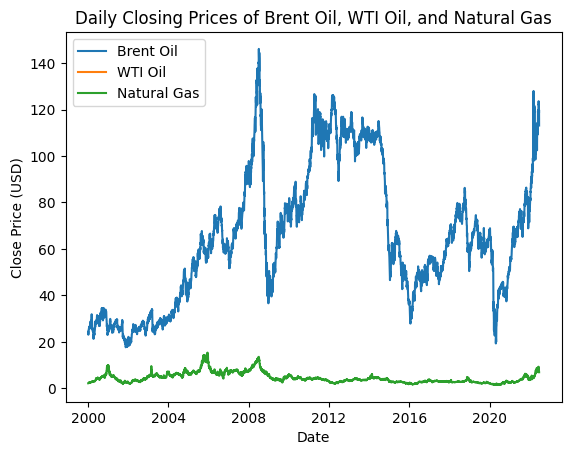

In [11]:
#Plot price time series
import matplotlib.pyplot as plt

plt.figure()
for symbol in symbols_of_interest:
    data_symbol = df_sub[df_sub["Symbol"] == symbol]
    plt.plot(data_symbol["Date"], data_symbol["Close"], label=symbol)

plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.title("Daily Closing Prices of Brent Oil, WTI Oil, and Natural Gas")
plt.legend()
plt.show()

# Note the WTI Oil is fully covered by Brent Oil

From the chart, you can clearly see:

2003–2008: Rapid rise

2008: Financial crisis crash

2011–2014: High-level consolidation

2014–2016: Oil price collapse

2020: COVID-19 shock

2022: Geopolitical shock

Calculate the rate of return, 
$$
Return_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$


In [14]:
#Calculate the rate of return
df_sub["Return"] = df_sub.groupby("Symbol")["Close"].transform(
    lambda x: x.pct_change()
)

df_sub 

,Symbol,Date,Open,High,Low,Close,Volume,Currency,Return
0,Brent Oil,2000-01-04,23.900,24.700,23.890,24.390,32509,USD,NaN
11512,Natural Gas,2000-01-04,2.130,2.200,2.130,2.176,30152,USD,NaN
11513,Natural Gas,2000-01-05,2.180,2.200,2.125,2.168,27946,USD,-0.003676
1,Brent Oil,2000-01-05,24.250,24.370,23.700,23.730,30310,USD,-0.027060
11514,Natural Gas,2000-01-06,2.165,2.220,2.135,2.196,29071,USD,0.012915
...,...,...,...,...,...,...,...,...,...
17251,Natural Gas,2022-06-15,7.269,7.698,7.201,7.420,123589,USD,0.032132
5766,Brent Oil,2022-06-16,119.650,120.290,115.560,119.810,276675,USD,0.010970
17252,Natural Gas,2022-06-16,7.540,8.027,7.330,7.464,137433,USD,0.005930
5767,Brent Oil,2022-06-17,119.130,121.250,111.720,113.120,319905,USD,-0.055838


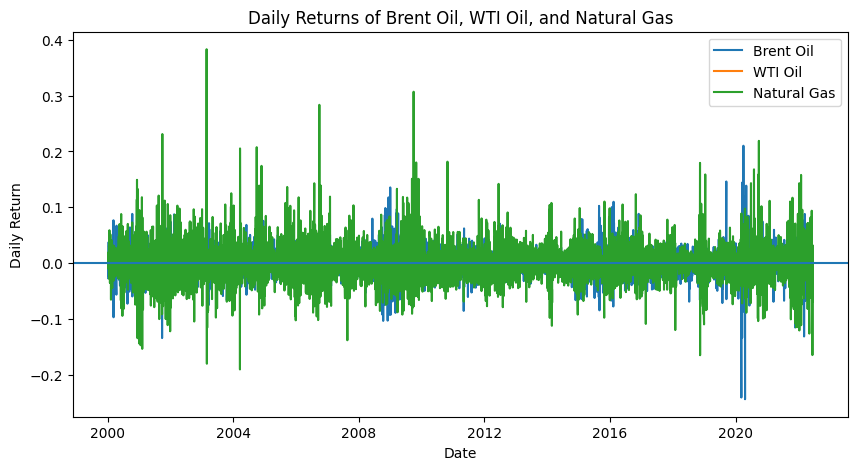

In [ ]:

# choose symbols of interest and sort by date
symbols = ["Brent Oil", "WTI Oil", "Natural Gas"]
df = df[df["Symbol"].isin(symbols)].copy()
df.sort_values(["Symbol", "Date"], inplace=True)

# calculate daily return
df["Return"] = df.groupby("Symbol")["Close"].transform(
    lambda x: x.pct_change()
)

# ===== Daily Return graph =====
plt.figure(figsize=(10, 5))
for s in symbols:
    tmp = df[df["Symbol"] == s]
    plt.plot(tmp["Date"], tmp["Return"], label=s)

plt.axhline(0)
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("Daily Returns of Brent Oil, WTI Oil, and Natural Gas")
plt.legend()
plt.show()


Interpretation of the Daily Return Plot

Volatility clustering is clearly observed, as large return fluctuations tend to occur in consecutive periods, while low-volatility periods also persist over time.
This indicates time-varying volatility and motivates the use of GARCH-type models.

Extreme positive and negative returns appear in specific periods, rather than being randomly distributed.
These spikes are associated with major events such as financial crises, the COVID-19 pandemic, and geopolitical shocks.

The presence of extreme returns suggests heavy-tailed behavior, indicating that energy commodity returns do not follow a normal distribution.
This highlights the importance of modeling tail risk in energy markets.

In [17]:
from arch import arch_model

# 1. select Brent Oil
brent = df[df["Symbol"] == "Brent Oil"].copy()
brent.sort_values("Date", inplace=True)

# 2. calculate daily returns in percentage
brent["Return"] = brent["Close"].pct_change() * 100
brent = brent.dropna()

# 4. construct GARCH(1,1) model
garch11 = arch_model(
    brent["Return"],
    mean="Constant",  
    vol="GARCH",       # GARCH model
    p=1, q=1,          # GARCH(1,1)
    dist="normal"      # normal distribution
)

# 5. fit the model
result = garch11.fit(disp="off")

print(result.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12239.3
Distribution:                  Normal   AIC:                           24486.7
Method:            Maximum Likelihood   BIC:                           24513.3
                                        No. Observations:                 5767
Date:                Sun, Feb 01 2026   Df Residuals:                     5766
Time:                        22:52:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0805  2.417e-02      3.329  8.727e-04 [3.308e-0

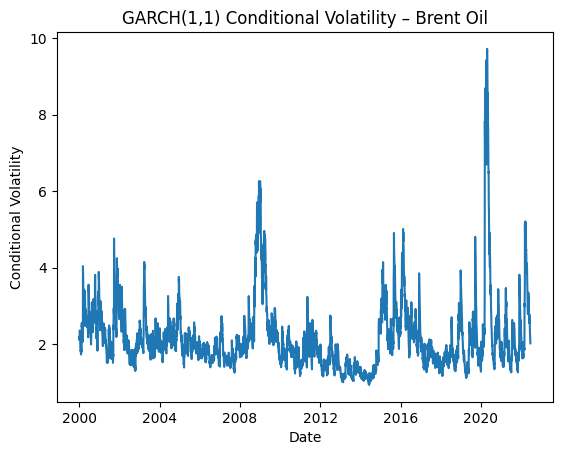

In [18]:
plt.figure()
plt.plot(brent["Date"], result.conditional_volatility)
plt.xlabel("Date")
plt.ylabel("Conditional Volatility")
plt.title("GARCH(1,1) Conditional Volatility – Brent Oil")
plt.show()
